###Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import pandas as pd
import os, shutil
from os import listdir
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
!gdown --id '1l8YzfPxHeMuLfUdSILbbb7gK98d3a9Ja'
!unzip -q split_.zip

Downloading...
From: https://drive.google.com/uc?id=1l8YzfPxHeMuLfUdSILbbb7gK98d3a9Ja
To: /content/split_.zip
100% 4.56G/4.56G [00:38<00:00, 119MB/s] 


In [ ]:
# check
path, dirs, files = next(os.walk("content/drive/MyDrive/split/train/negative"))
print("train neg ",len(files))
path, dirs, files = next(os.walk("content/drive/MyDrive/split/train/positive"))
print("train pos ",len(files))
path, dirs, files = next(os.walk("content/drive/MyDrive/split/test/negative"))
print("test neg ",len(files))
path, dirs, files = next(os.walk("content/drive/MyDrive/split/test/positive"))
print("test pos ",len(files))
path, dirs, files = next(os.walk("content/drive/MyDrive/split/val/negative"))
print("val neg ",len(files))
path, dirs, files = next(os.walk("content/drive/MyDrive/split/val/positive"))
print("val pos ",len(files))

train neg  2484
train pos  2484
test neg  359
test pos  45
val neg  363
val pos  44


### Transform to tensor

In [2]:
# raw img size 4040 * 5416 pixel
wid = 1000
hgt = 1000

train_tfm = transforms.Compose([
    transforms.Resize((1000, 1000)),
    # transforms.ColorJitter(contrast=1),
    # transforms.RandomRotation(degrees = 8, fill = 1),
    # transforms.Resize((128, 128)),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

test_tfm = transforms.Compose([
    transforms.Resize((1000, 1000)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# input[512, 1, 28, 28]

### Build Dataset

In [3]:
batch_size = 16
#train_set = datasets.DatasetFolder("split/train", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
subtrain_set = datasets.DatasetFolder("split/train", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = datasets.DatasetFolder("split/val", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
test_set = datasets.DatasetFolder("split/test", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

#train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True) # , num_workers=8, pin_memory=True
subtrain_loader = DataLoader(subtrain_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

### MLP (博任)

In [4]:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)
#CUDA_LAUNCH_BLOCKING=1
use_cuda = torch.cuda.is_available()
device = torch.device("cpu")

In [5]:
from torch.nn.modules.activation import Sigmoid
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [1, 784, 784]  (C H W)
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(16, 32, 3, 1, 1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(32, 64, 3, 1, 1),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(1000000, 128),  # * 196 * 196
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 28, 28]
        # output: [batch_size, 2]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x


In [6]:
device = "cpu"
print("Running on device: ", device)
my_model = Classifier().to(device)
my_model.device = device

Running on device:  cpu


In [7]:
# define the optimizer
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.0001)
# Binary Cross Entropy Loss
loss_fn = torch.nn.BCELoss()
#loss_fn = nn.BCEWithLogitsLoss()

In [9]:
nepoch = 100
step_count = 0
log_interval = 10
#trainingAccuracy_list = []
#validationAccuracy_list = []
trainingloss_list = []
validloss_list = []
step_count_list = []
#train_ncorrect = 0
#train_test_nobs = 0
cumulative_loss = 0
countdown = 100


for epoch_id in range(0, nepoch):    
    if countdown == 0:
        print("early stop2")
        break  
    for batch_idx, (inputs, targets) in enumerate(subtrain_loader):
        #reshape target to two-dimensional array
        targets = targets.reshape((-1, 1))
        step_count += 1        
        my_model.train()
        #print(inputs)
        #print(targets)
        inputs, targets = inputs.to(device), targets.to(device)
      
        optimizer.zero_grad()
        #batch_size = inputs.shape[0]
        #inputs = inputs.view(batch_size, -1)
        outputs = my_model(inputs)   
        targets = targets.float()
        loss = loss_fn(outputs, targets)
        cumulative_loss += loss

        #train_pred = (outputs.cpu().detach().numpy() > 0.5).astype('float32')
        #train_tmp_correct = (train_pred == targets.cpu().detach().numpy()).sum()
        #train_ncorrect += train_tmp_correct
        #train_test_nobs += len(train_pred) 
  
        loss.backward()
        optimizer.step()
        #if step_count % log_interval == 0: 
        if step_count % log_interval == 0:
            step_count_list.append(step_count)
            #trainingAccuracy = train_ncorrect / train_test_nobs
            #valid_ncorrect = 0
            #valid_test_nobs = 0
            validoutputs_list = []
            validtargets_list = []
            with torch.no_grad():
              for i, (validinputs, validtargets) in enumerate(valid_loader):
                if i == 0:
                  print("Calculating Loss...")
                my_model.eval()
                validtargets = validtargets.reshape((-1, 1))
                validinputs, validtargets = validinputs.to(device), validtargets.to(device)
                #batch_size = validinputs.shape[0]
                #validinputs = validinputs.view(batch_size, -1)
                validoutputs = my_model(validinputs) 
                validtargets = validtargets.float()
                validoutputs_list.append(validoutputs)
                validtargets_list.append(validtargets)
                #valid_pred = (validoutputs.cpu().detach().numpy() > 0.5).astype('float32')
                #valid_tmp_correct = (valid_pred == validtargets.cpu().detach().numpy()).sum()
                #valid_ncorrect += valid_tmp_correct
                #valid_test_nobs += len(valid_pred) 
            #validationAccuracy = valid_ncorrect / valid_test_nobs
            validoutputs_array = np.array(validoutputs_list)
            for i in range(len(validoutputs_array)):
              validoutputs_array[i] = validoutputs_array[i].to("cpu")
              validoutputs_array[i] = validoutputs_array[i].numpy()
            full_valid_outputs = np.concatenate(validoutputs_array, axis=0 )
            validtargets_array = np.array(validtargets_list)
            for i in range(len(validtargets_array)):
              validtargets_array[i] = validtargets_array[i].to("cpu")
              validtargets_array[i] = validtargets_array[i].numpy()
            full_valid_targets = np.concatenate(validtargets_array, axis=0 )
            validloss = loss_fn(torch.tensor(full_valid_outputs), torch.tensor(full_valid_targets))
            trainingloss = cumulative_loss / step_count
            #trainingAccuracy_list.append(trainingAccuracy)
            #validationAccuracy_list.append(validationAccuracy)
            trainingloss_list.append(trainingloss.item())
            validloss_list.append(validloss.item())
            print("Epoch %d Batch %d: trainingLoss = %.3f, validationLoss = %.3f (minibatch size = %d)" % (epoch_id, step_count, trainingloss.item(), validloss.item(), len(targets)))
            #print("Epoch %d Batch %d: trainingAccuracy = %.3f, validationAccuracy = %.3f (minibatch size = %d)" % (epoch_id, step_count, trainingAccuracy, validationAccuracy, len(targets)))        
            if step_count < 20:
                before_lowestloss = validloss
                PATH = './CNN_final.pth' #save model
                torch.save(my_model.state_dict(), PATH)
                
            elif step_count >=20:
                if validloss < before_lowestloss:
                    print("Oh yah") #爽啦，進步了！
                    PATH = './CNN_final.pth' #save model
                    torch.save(my_model.state_dict(), PATH)
                    before_lowestloss = validloss
                    countdown = 100 #經過1000個batch相當於經過100個10個batch
                else:
                    countdown -= 1
            if countdown == 0:
                print("early stop1") #好了啦
                break

Calculating Loss...


C:\Users\oplab\AppData\Local\Temp/ipykernel_4144/1098009433.py:69: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  validoutputs_array = np.array(validoutputs_list)
C:\Users\oplab\AppData\Local\Temp/ipykernel_4144/1098009433.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validoutputs_array = np.array(validoutputs_list)
C:\Users\oplab\AppData\Local\Temp/ipykernel_

Epoch 0 Batch 10: trainingLoss = 0.869, validationLoss = 0.699 (minibatch size = 16)
Calculating Loss...
Epoch 0 Batch 20: trainingLoss = 0.781, validationLoss = 0.671 (minibatch size = 16)
Oh yah
Calculating Loss...
Epoch 0 Batch 30: trainingLoss = 0.753, validationLoss = 0.816 (minibatch size = 16)
Calculating Loss...
Epoch 0 Batch 40: trainingLoss = 0.741, validationLoss = 0.608 (minibatch size = 16)
Oh yah
Calculating Loss...
Epoch 0 Batch 50: trainingLoss = 0.723, validationLoss = 0.582 (minibatch size = 16)
Oh yah
Calculating Loss...
Epoch 0 Batch 60: trainingLoss = 0.715, validationLoss = 0.771 (minibatch size = 16)
Calculating Loss...
Epoch 0 Batch 70: trainingLoss = 0.712, validationLoss = 0.533 (minibatch size = 16)
Oh yah
Calculating Loss...
Epoch 0 Batch 80: trainingLoss = 0.707, validationLoss = 0.594 (minibatch size = 16)
Calculating Loss...
Epoch 0 Batch 90: trainingLoss = 0.703, validationLoss = 0.585 (minibatch size = 16)
Calculating Loss...
Epoch 0 Batch 100: training

In [10]:
my_model.load_state_dict(torch.load(PATH)) #use the saved model to test

<All keys matched successfully>

In [11]:
my_model.eval()
print("Doing model testing...")
test_nobs = 0
ncorrect = 0
pred_list = []
true_list = []
outputs_list = []
targets_list = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):            
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.reshape((-1, 1))
        #batch_size = inputs.shape[0]
        #inputs = inputs.view(batch_size, -1)
        outputs = my_model(inputs)
        targets = targets.float()
        outputs_list.append(outputs)
        targets_list.append(targets)              
        pred = (outputs.cpu().numpy() > 0.5).astype('float32')
        pred_list.extend(pred.flatten().tolist())
        true_list.extend(targets.flatten().tolist())
        tmp_correct = (pred == targets.cpu().numpy()).sum()
        ncorrect += tmp_correct
        test_nobs += len(pred)        
accuracy = ncorrect / test_nobs
#print(np.array(outputs_list))
#print(np.array(outputs_list).shape)
#print(np.array(targets_list))
#print(np.array(targets_list).shape)
outputs_array = np.array(outputs_list)
for i in range(len(outputs_array)):
  outputs_array[i] = outputs_array[i].to("cpu")
  outputs_array[i] = outputs_array[i].numpy()
full_test_outputs = np.concatenate(outputs_array, axis=0 )
targets_array = np.array(targets_list)
for i in range(len(targets_array)):
  targets_array[i] = targets_array[i].to("cpu")
  targets_array[i] = targets_array[i].numpy()
full_test_targets = np.concatenate(targets_array, axis=0 )
testloss = loss_fn(torch.tensor(full_test_outputs), torch.tensor(full_test_targets))
print("Test loss = %.3f" % testloss.item())
print("Accuracy = %.3f" % accuracy)

Doing model testing...
Test loss = 0.386
Accuracy = 0.874


C:\Users\oplab\AppData\Local\Temp/ipykernel_4144/4192451914.py:30: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  outputs_array = np.array(outputs_list)
C:\Users\oplab\AppData\Local\Temp/ipykernel_4144/4192451914.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  outputs_array = np.array(outputs_list)
C:\Users\oplab\AppData\Local\Temp/ipykernel_4144/4192451914.py:3

In [12]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
print(metrics.classification_report(true_list, pred_list))
print("AUC:",roc_auc_score(true_list, pred_list))

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       359
         1.0       0.35      0.16      0.22        45

    accuracy                           0.87       404
   macro avg       0.63      0.56      0.57       404
weighted avg       0.84      0.87      0.85       404

AUC: 0.5596719281956051


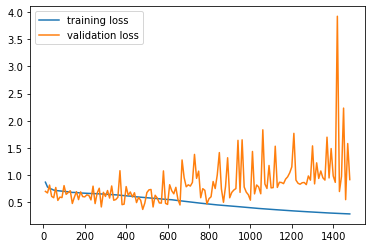

In [13]:
import matplotlib.pyplot as plt
plt.plot(step_count_list, trainingloss_list, label = "training loss")
plt.plot(step_count_list, validloss_list, label = "validation loss")
plt.legend()
plt.show()

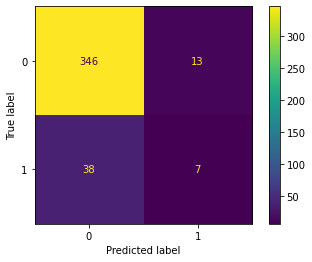

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_list, pred_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()